# Breast Cancer P1

Para classificar o exercício da prova, vamos transformar a regressão logística em uma rede neural. Primeiramente daremos um exemplo simples para depois deixar explíctio as camadas ocultas.

In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_coimbra = fetch_ucirepo(id=451)

# data (as pandas dataframes)
X = breast_cancer_coimbra.data.features
y = breast_cancer_coimbra.data.targets

# metadata
print(breast_cancer_coimbra.metadata)

# variable information
print(breast_cancer_coimbra.variables)


{'uci_id': 451, 'name': 'Breast Cancer Coimbra', 'repository_url': 'https://archive.ics.uci.edu/dataset/451/breast+cancer+coimbra', 'data_url': 'https://archive.ics.uci.edu/static/public/451/data.csv', 'abstract': 'Clinical features were observed or measured for 64 patients with breast cancer and 52 healthy controls. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 116, 'num_features': 9, 'feature_types': ['Integer'], 'demographics': ['Age'], 'target_col': ['Classification'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C52P59', 'creators': ['Miguel Patrcio', 'Jos Pereira', 'Joana Crisstomo', 'Paulo Matafome', 'Raquel Seia', 'Francisco Caramelo'], 'intro_paper': {'title': 'Using Resistin, glucose, age and BMI to predict the presence of breast cancer', 'authors': 'M. Patrício, J. Pereira, J. Cri

In [5]:
y.Classification = y.Classification - 1

<ipython-input-5-383257e8f4ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.Classification = y.Classification - 1


In [6]:
y.Classification

0      0
1      0
2      0
3      0
4      0
      ..
111    1
112    1
113    1
114    1
115    1
Name: Classification, Length: 116, dtype: int64

In [9]:
for idx in X.columns:
    X[idx] = (X[idx]-X[idx].mean())/X[idx].std()

<ipython-input-9-d0a98078d2e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[idx] = (X[idx]-X[idx].mean())/X[idx].std()


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
54,-0.515227,-1.319786,-0.168394,0.227748,0.043418,-0.801452,-0.258455,0.677264,0.112696
75,-0.887602,-0.203104,0.142370,0.053926,-0.017953,-0.876548,-0.549524,0.110893,0.786548
102,0.477775,0.664019,-0.035210,0.047569,-0.050752,0.907384,-0.945559,0.463457,-0.398942
47,1.284589,-0.454591,-1.677817,-0.646031,-0.597413,-1.041640,0.056467,-0.812078,-0.939249
85,0.477775,0.415215,-0.567947,0.460570,0.103354,-0.005134,-0.423478,0.382327,3.364413
...,...,...,...,...,...,...,...,...,...
25,-0.763477,1.883116,-0.656737,-0.323020,-0.359960,0.696706,-0.813016,-0.485970,0.148957
78,1.781089,-0.182354,4.581849,3.138622,4.924639,1.096366,-0.704881,0.778340,3.364413
45,0.539838,0.023483,-0.345973,-0.394336,-0.371677,-0.092220,-0.369530,-0.647324,-0.892615
55,-1.446165,-0.665258,-0.257184,1.160825,0.612085,-0.515020,1.701343,-0.214729,-0.152345


In [14]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as at

In [13]:
coords = {"features" : [idx for idx in X.columns]}
coords

{'features': ['Age',
  'BMI',
  'Glucose',
  'Insulin',
  'HOMA',
  'Leptin',
  'Adiponectin',
  'Resistin',
  'MCP.1']}

In [38]:
y_train.Classification.values

array([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1])

In [64]:
with pm.Model(coords=coords) as model_1:
  X_m = [
    pm.MutableData("X_"+column,X_train[column].values)
    for column in X_train.columns if np.issubdtype(X_train[column].dtype, np.number)
  ]
  y_m = pm.MutableData("y",y_train.Classification.values)

  betas_h_0 = pm.Normal("beta0",0,1,dims="features")
  alpha_h_0 = pm.Normal("alpha0",0,1)
  betas_h_1 = pm.Normal("beta1",0,1,dims="features")
  alpha_h_1 = pm.Normal("alpha1",0,1)

  act = [ pm.math.tanh(alpha_h_0 + at.dot(betas_h_0,X_m))
        , pm.math.tanh(alpha_h_1 + at.dot(betas_h_1,X_m)) ]

  betas_o = pm.Normal("beta_o",0,1,shape=len(act))
  alpha_o = pm.Normal("alpha_o",0,1)
  mu = alpha_o + at.dot(betas_o,act)

  likelihood = pm.Bernoulli("likelihood",pm.math.invlogit(mu),observed=y_m)

In [65]:
with model_1:
  trace = pm.sample()

In [66]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0[Age],-0.049,0.776,-1.557,1.430,0.037,0.026,417.0,638.0,1.00
beta0[BMI],0.005,0.896,-1.588,1.618,0.068,0.048,185.0,981.0,1.00
beta0[Glucose],0.042,1.518,-2.455,2.675,0.151,0.107,108.0,786.0,1.00
beta0[Insulin],-0.002,0.867,-1.533,1.700,0.036,0.026,569.0,1092.0,1.00
beta0[HOMA],-0.027,0.968,-1.893,1.858,0.040,0.029,568.0,1271.0,1.00
beta0[Leptin],0.024,0.870,-1.548,1.755,0.033,0.023,688.0,967.0,1.00
beta0[Adiponectin],-0.008,0.790,-1.693,1.409,0.035,0.025,499.0,813.0,1.01
beta0[Resistin],0.012,1.372,-2.268,2.441,0.126,0.089,130.0,977.0,1.00
beta0[MCP.1],0.007,0.717,-1.460,1.328,0.019,0.017,1412.0,1102.0,1.00
alpha0,0.019,0.956,-1.645,1.878,0.048,0.034,385.0,790.0,1.00


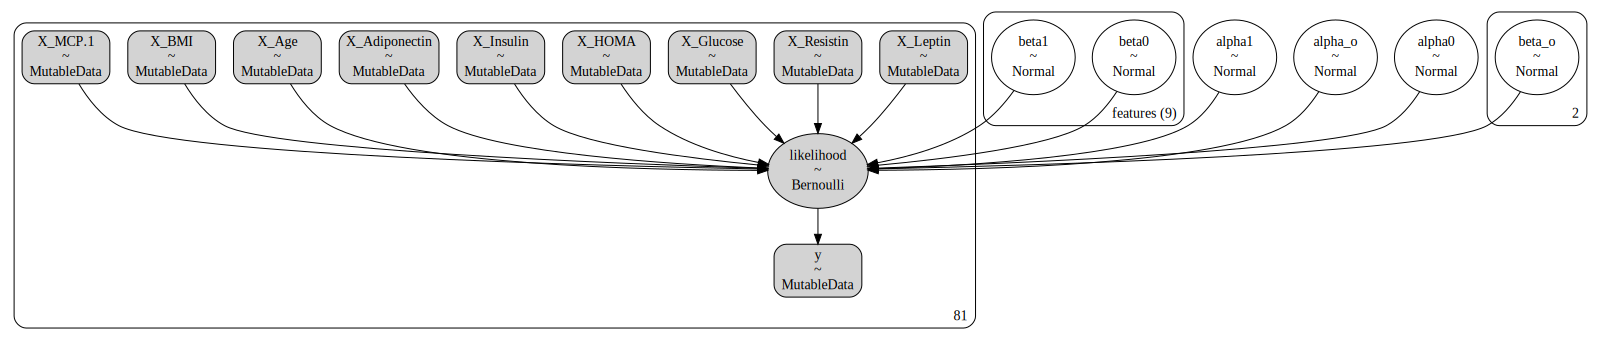

In [67]:
pm.model_to_graphviz(model_1)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'alpha0'}>,
        <Axes: title={'center': 'alpha0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'alpha1'}>,
        <Axes: title={'center': 'alpha1'}>],
       [<Axes: title={'center': 'beta_o'}>,
        <Axes: title={'center': 'beta_o'}>],
       [<Axes: title={'center': 'alpha_o'}>,
        <Axes: title={'center': 'alpha_o'}>]], dtype=object)

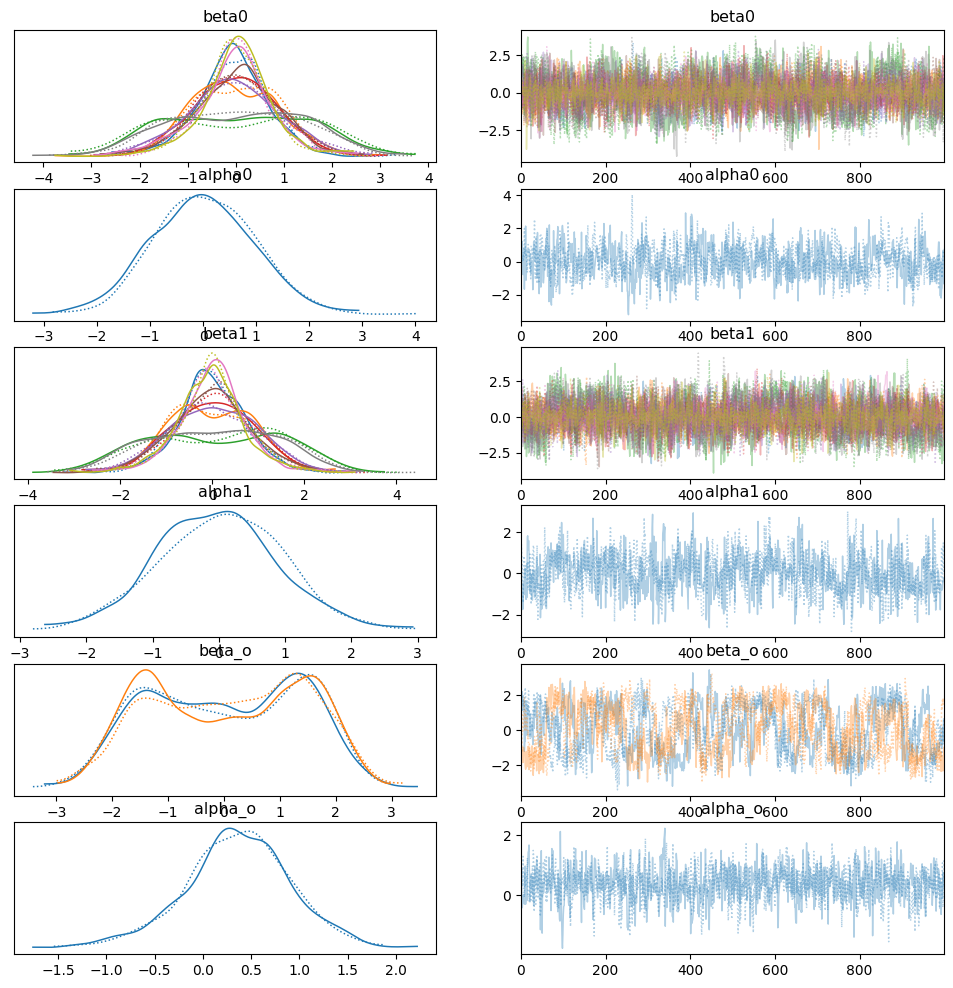

In [68]:
az.plot_trace(trace)

In [71]:
vars = {"X_"+column : X_test[column].values
    for column in X_test.columns if np.issubdtype(X_test[column].dtype, np.number)}
vars["y"] = y_test.Classification.values

In [72]:
with model_1:
  pm.set_data(vars)
  trace_post = pm.sample_posterior_predictive(trace)

In [73]:
mean_likelihood = trace_post.posterior_predictive['likelihood'].mean(dim=['chain', 'draw'])
binary_predictions = (mean_likelihood > 0.5).astype(int)

In [74]:
import pandas as pd
abs_diff = np.abs(y_test.Classification.values - binary_predictions)

df = pd.DataFrame({
    'y_test': y_test.Classification.values,
    'binary_predictions': binary_predictions,
    'abs_diff': abs_diff
})

df

,y_test,binary_predictions,abs_diff
0,0,0,0
1,1,0,1
2,0,1,1
3,0,1,1
4,1,1,0
5,0,1,1
6,1,1,0
7,0,1,1
8,0,0,0
9,0,0,0


In [75]:
errors = df["abs_diff"].sum()
acc = (len(df)-errors)/len(df)
print(f"Acuracia: {acc:.4f}")
print(f"Erros: {errors}")

Acuracia: 0.7143
Erros: 10


In [76]:
class1 = df["y_test"].sum()
class0 = len(df)-class1

print(f"Classe 0: {class0}")
print(f"Classe 1: {class1}")

Classe 0: 16
Classe 1: 19


In [77]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, binary_predictions)

recall = recall_score(y_test, binary_predictions)

f1 = f1_score(y_test, binary_predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.7143
Recall: 0.7895
F1 Score: 0.7500


# Redes Neurais

Podemos incrementar o modelo de regressão linear Bayesiano e transformá-lo em uma rede neural. As inclinações terão a nomenclatura de pesos e os interceptos de viés (bias).

## Fórmula Geral da Rede Neural

A fórmula para uma rede neural com três camadas ocultas, por exemplo, é representada da seguinte forma:

### Primeira Camada Oculta (Hidden Layer 1):

$ z^{[1]} = W^{[1]} \cdot x + b^{[1]} $

$ a^{[1]} = g^{[1]}(z^{[1]}) $

onde $ g^{[1]} $ é a função de ativação da primeira camada (por exemplo, a tangente hiperbólica).

### Segunda Camada Oculta (Hidden Layer 2):

$ z^{[2]} = W^{[2]} \cdot a^{[1]} + b^{[2]} $

$ a^{[2]} = g^{[2]}(z^{[2]}) $

### Terceira Camada Oculta (Hidden Layer 3):

$ z^{[3]} = W^{[3]} \cdot a^{[2]} + b^{[3]} $

$ a^{[3]} = g^{[3]}(z^{[3]}) $

### Camada de Saída (Output Layer):

$ z^{[4]} = W^{[4]}a^{[3]} + b^{[4]} $

$ \mu = g^{[4]}(z^{[4]}) $

onde $ g^{[4]} $ pode ser uma função de ativação adequada ao tipo de problema (por exemplo, logit para classificação).


## Distribuições a Priori

As priori neste exemplo serão todas Normais, pelo fato de proporcionarem uma modelagem flexível e serem computacionalmente convenientes para o ajuste dos parâmetros via técnicas como o método de Monte Carlo via Cadeias de Markov (MCMC), essencial para a estimação de posteriores em contextos Bayesianos.

## Processo de Aprendizado

O aprendizado na rede neural é realizado através do ajuste dos pesos $W^{[l]}$ e viés $b^{[l]}$ para minimizar a função de erro.

No exemplo da prova, faremos duas camadas ocultas de tamaho 3 e 2.


In [112]:
nnet = [3,2,4]
with pm.Model(coords=coords) as model_3:
  X_m = [
    pm.MutableData("X_"+column,X_train[column].values)
    for column in X_train.columns if np.issubdtype(X_train[column].dtype, np.number)
  ]
  y_m = pm.MutableData("y",y_train.Classification.values)
  betas_h = []
  alpha_h = []
  act = []
  layer = []
  for j in nnet:
    for i in range(j):
      betas_h.append(pm.Normal("beta_h" + str(j)+str(i),0,1,dims="features"))
      alpha_h.append(pm.Normal("alpha_h" + str(j)+str(i),0,1))

      act.append(pm.math.tanh(alpha_h[i] + at.dot(betas_h[i],X_m)))
    betas_i = pm.Normal("beta_i"+str(j),0,1,shape=len(act))
    alpha_i = pm.Normal("alpha_i"+str(j),0,1)
    layer.append(pm.math.tanh(alpha_i + at.dot(betas_i,act)))
    betas_h = []
    aplha_h = []
    act = []

  betas_o = pm.Normal("beta_o",0,1,shape=len(layer))
  alpha_o = pm.Normal("alpha_o",0,1)
  mu = alpha_o + at.dot(betas_o,layer)

  likelihood = pm.Bernoulli("likelihood",pm.math.invlogit(mu),observed=y_m)

In [113]:
with model_3:
  trace_3 = pm.sample()

In [118]:
pm.summary(trace_3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_h30[Age],0.043,0.949,-1.735,1.835,0.026,0.023,1302.0,1108.0,1.00
beta_h30[BMI],0.010,0.965,-1.729,1.942,0.028,0.021,1194.0,1406.0,1.00
beta_h30[Glucose],-0.028,1.091,-2.066,1.978,0.039,0.028,785.0,950.0,1.00
beta_h30[Insulin],-0.006,0.989,-1.952,1.718,0.029,0.023,1195.0,1351.0,1.00
beta_h30[HOMA],0.002,0.990,-1.740,1.920,0.025,0.025,1622.0,1078.0,1.00
...,...,...,...,...,...,...,...,...,...
alpha_i4,-0.000,0.909,-1.829,1.562,0.030,0.021,920.0,1081.0,1.00
beta_o[0],-0.043,1.291,-2.318,2.258,0.107,0.076,148.0,586.0,1.02
beta_o[1],-0.131,1.251,-2.345,2.070,0.092,0.065,184.0,608.0,1.01
beta_o[2],0.257,1.420,-2.221,2.572,0.124,0.088,135.0,549.0,1.03


/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (26), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'beta_h30'}>,
        <Axes: title={'center': 'beta_h30'}>],
       [<Axes: title={'center': 'alpha_h30'}>,
        <Axes: title={'center': 'alpha_h30'}>],
       [<Axes: title={'center': 'beta_h31'}>,
        <Axes: title={'center': 'beta_h31'}>],
       [<Axes: title={'center': 'alpha_h31'}>,
        <Axes: title={'center': 'alpha_h31'}>],
       [<Axes: title={'center': 'beta_h32'}>,
        <Axes: title={'center': 'beta_h32'}>],
       [<Axes: title={'center': 'alpha_h32'}>,
        <Axes: title={'center': 'alpha_h32'}>],
       [<Axes: title={'center': 'beta_i3'}>,
        <Axes: title={'center': 'beta_i3'}>],
       [<Axes: title={'center': 'alpha_i3'}>,
        <Axes: title={'center': 'alpha_i3'}>],
       [<Axes: title={'center': 'beta_h20'}>,
        <Axes: title={'center': 'beta_h20'}>],
       [<Axes: title={'center': 'alpha_h20'}>,
        <Axes: title={'center': 'alpha_h20'}>],
       [<Axes: title={'center': 'beta_h21'}>,
        <Axes: tit

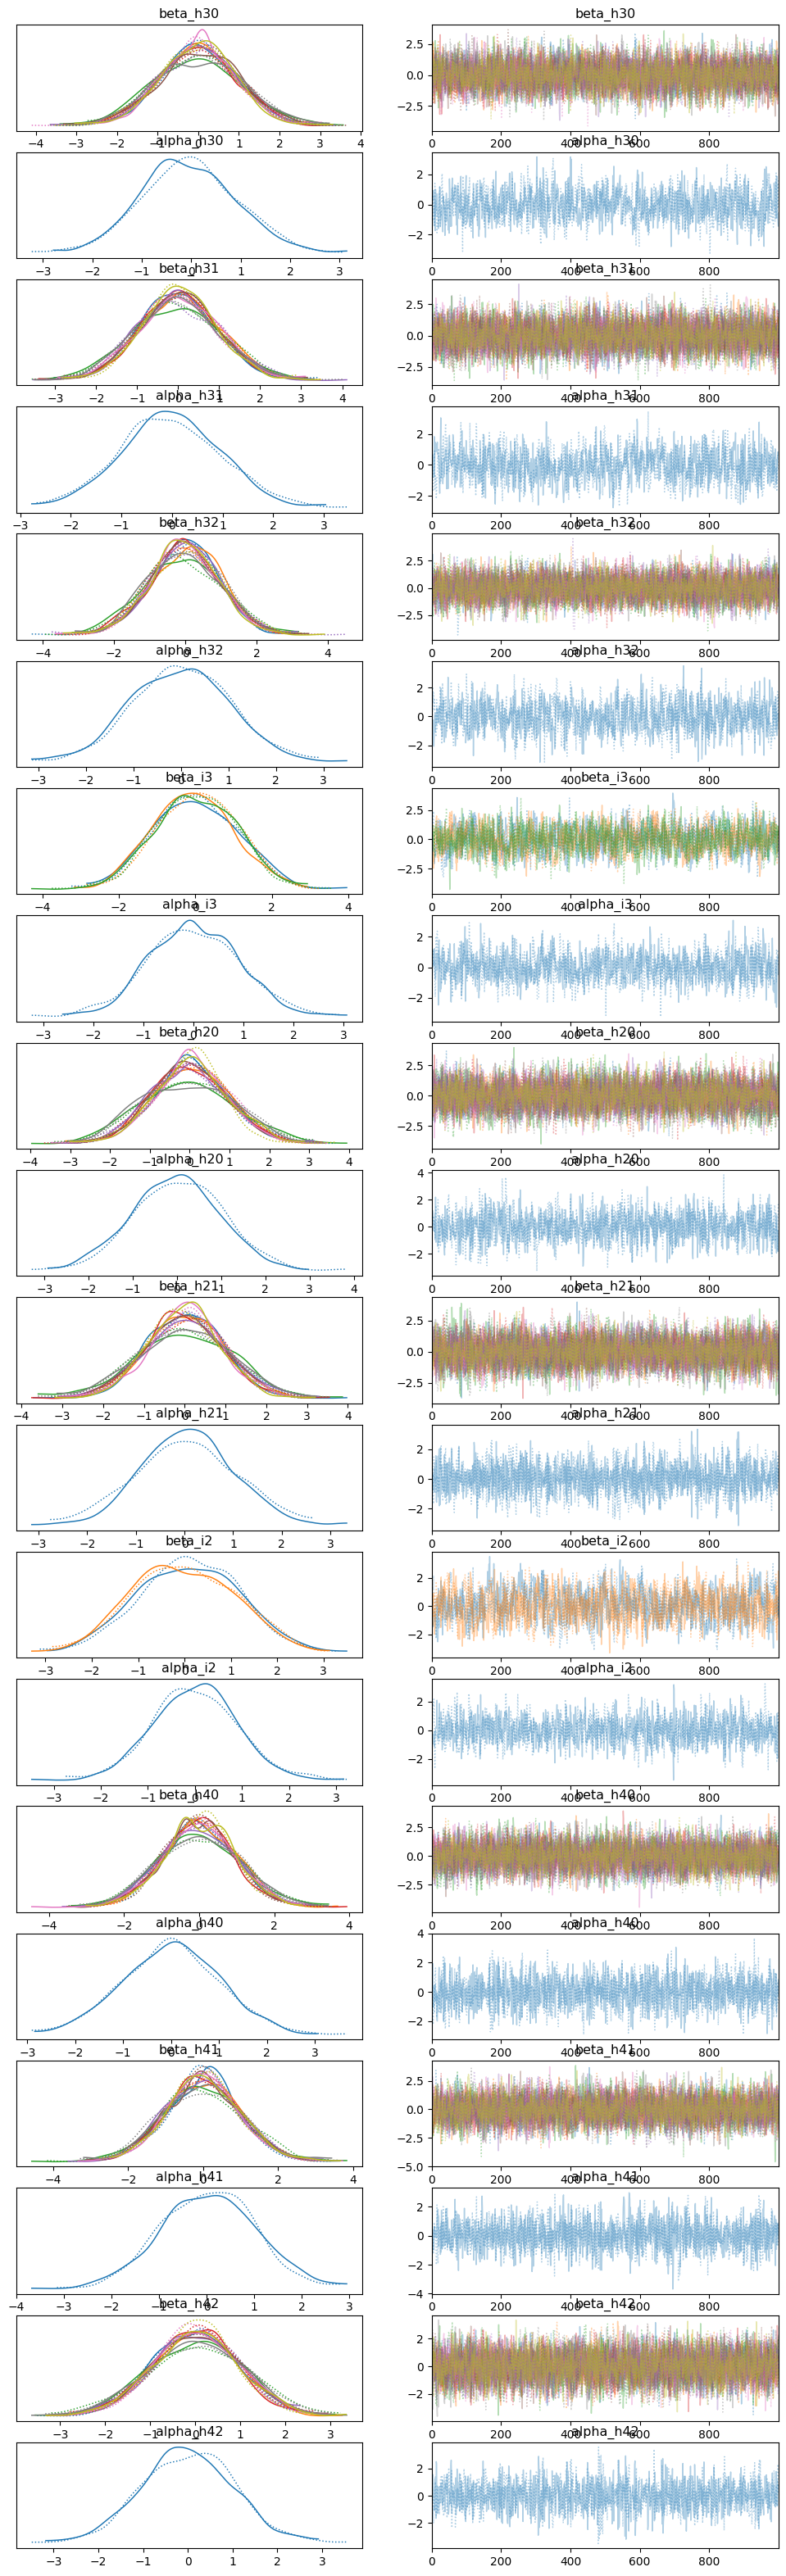

In [120]:
az.plot_trace(trace_3)

In [114]:
with model_3:
  pm.set_data(vars)
  trace_post_3 = pm.sample_posterior_predictive(trace_3)

In [115]:
mean_likelihood = trace_post_3.posterior_predictive['likelihood'].mean(dim=['chain', 'draw'])
binary_predictions = (mean_likelihood > 0.5).astype(int)

In [116]:
abs_diff = np.abs(y_test.Classification.values - binary_predictions)
errors = abs_diff.sum()
acc = (len(df)-errors)/len(df)
print(f"Acuracia: {acc:.4f}")
print(f"Erros: {errors:d}")

Acuracia: 0.7429
Erros: 9
